# Notebook contains:

* Timing tests notes
* Plotting tool to compare different paths, and plot time logs
* Fitting piecewise linear function
* reading in the tif with weights
* Faster edge convolutions
* read start and dest from tifs

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import os
from PIL import Image
import rasterio
import time
import json
from graph_tool.all import *

In [13]:
from power_planner.utils import *

## Next meeting:

* path straightening in constraints notebook with algorithm is not an actual straightening

### Explain pipeline:

* Get hard constraints --> binary corridor, + water etc
* Add one node to the graph for each raster cell in the corridor
* Define donut around each cell
* Add edges between each point and the point in the donut around it, with weights:
    * First option: sum of cost of both cells of these two nodes
    * Second option: sum of cost of all cells inbetween --> Bresenham line (other notebook)
* Add start and end node, and connect to the top x and bottom x points of the corridor with weight 0
* Run shortest path algorithm (bellman ford)

So far: downscaling with different factors

### Runtimes:

**Scale by 5 --> 20 poins in donut**
* edge convolutions: {'init_graph': 0.03, 'add_nodes': 1.676, **'edge_list (per convolution!)': 0.9, 'add_edges (per shift)': 0.0045**, 'start_end_vertex': 0.004, 'shortest_path': 0.363}
* node adding: {'init_graph': 0.03, 'add_nodes': 1.376, **'edge_list': 0.00245, 'add_edges': 0.00665,** 'start_end_vertex': 0.005, 'shortest_path': 0.236}
* old edge version {'init_graph': 0.031, 'add_nodes': 1.481, **'edge_list': 0.198, 'add_edges': 0.045**, 'start_end_vertex': 0.003, 'shortest_path': 0.216}

--> add adges even longer if list not split?!, improved node constraints by factor of 80

**networkx scale 5:**
* bellman ford: {'init_graph': 0.037, 'add_nodes': 0.03, 'edge_list': 0.002, **'add_edges': 0.2996**, 'start_end_vertex': 0.007, **'shortest_path': 2.961**}
* dijkstra: {'init_graph': 0.036, 'add_nodes': 0.03, 'edge_list': 0.0020000000000000005, 'add_edges': 0.2926000000000001, 'start_end_vertex': 0.004, 'shortest_path': 0.633}

--> graph-tool speed up: shortest path 10 times (bellman ford), 2 times (dijkstra), adding edges 60 times

**Scale by 2 --> 156 point in donut**
* edge convolutions with **faster convolutions**: {'init_graph': 0.233, 'add_nodes': 0.005, 'concatenate': 0.328, 'add_edges': 0.025, **'edge_list': 0.15**, 'start_end_vertex': 0.015, 'shortest_path': 27.296}
* edge convolutions: {'init_graph': 0.198, 'add_nodes': 9.569, **'edge_list': 6.908, 'add_edges': 0.0273**, 'start_end_vertex': 0.034, 'shortest_path': 32.844}
* node adding: {'init_graph': 0.202, 'add_nodes': 9.458, **'edge_list': 0.0092, 'add_edges': 0.024,** 'start_end_vertex': 0.017, 'shortest_path': 7.76}
* node adding graph tool dijkstra: {'init_graph': 0.274, 'add_nodes': 0.006, 'edge_list': 0.010, 'add_edges': 0.029, 'start_end_vertex': 0.018, **'shortest_path': 0.822**}
* old edge version: {'init_graph': 0.206, 'add_nodes': 10.979, **'edge_list': 1.154, 'add_edges': 0.314,** 'start_end_vertex': 0.032, 'shortest_path': 7.492}
* networkx dijkstra: {'init_graph': 0.212, 'add_nodes': 0.156, 'edge_list': 0.01, **'add_edges': 3.08,** 'start_end_vertex': 0.065, **'shortest_path': 41.075**}

--> speed up of node constraint by factor of 125
--> graph tool speedup: 6 times for shortest path, 

**Whole instance: 428643 nodes --> around 263 615 445 edges**
* dijkstra does not work because out of memory, time is {'init_graph': 0.624, 'add_nodes': 0.021, 'edge_list': 0.065,**'add_edges': 1.179**, 'start_end_vertex': 0.61,**'shortest_path': 611.761**}
* with adding all edges at ones (bellman ford graph-tool): crashed 


**Directed graph:**
* speed up for shortest path by a lot! 
* scale 2 directed: 0.5 
* {'init_graph': 0.218, 'add_nodes': 0.005, 'add_edges': 0.024, 'edge_list': 0.12, **'shortest_path': 0.518**}
* scale 2 undirected: 8

**Other observations:**
* graph-tool becomes slower for adding edges, the more edges are in the graph already
* graph-tool with adding all edges at once: {'init_graph': 0.211, 'add_nodes': 0.005, 'add_edges': 0.026, 'edge_list': 0.017, 'start_end_vertex': 0.007, 'shortest_path': 6.554}
* **add_nodes is much faster when no generator is returned (and seems to work just as fine**

### Space efficiency:

* with dijkstra my laptop crashed, with bellman ford it's okay (for full instance --> 249 000 000 edges)
* scaled 2 still fine 15 912 513 edges

### Discuss:

* Angle constraints: 
    * Path straightening (other notebook) is actually sampling fewer points
    * Line graph takes m*1/3 d

### Questions:

Pipeline so far:

* Normalization: 0-1 normalization for cost surface?
* Bresenham line makes sense?
* Start and end node given? first row?
* networkx version

Constraints:

* Hard constraints: Distance from towns etc? Water?
* View on towers / cables constraint?
* Height of towers
* Monetary costs? --> node costs in addition, so it's not placing too many towers

How to use other tifs?? - Excel sheet

### meeting:

* infinity costs on edges for NaNs
* function to compute resistance: multiply raster tifs with weights
* the more negative the value, the more suitable
* completely forbidden: NaN or infinite
* MCDA negative values - but zickszack

Todo:
* flip coordinates

## Runtimes Linegraph

* Line graph: {'init_graph': 0.0, 'add_nodes': 1.7634360790252686, 'add_edges': 0.023, 'edge_list': 0.079, 'shortest_path': 15.495} for 878 iterations --> add_edges ca. 90 seconds
* normal graph: {'init_graph': 0.038, 'add_nodes': 0.001, 'add_edges': 0.003, 'edge_list': 0.002, 'shortest_path': 0.162}
* line graph from file:{'init_graph': 9.354, 'add_nodes': 0.028, 'add_edges': 48.366, 'edge_list': 902.766, 'shortest_path': 4.559}

# Plotting tool

In [386]:
compare_path = "../outputs/compare" # path_whole_instance_infos.json"

In [624]:
paths = []
files = []
for f in os.listdir(compare_path):
    if f[-4:]=="json":
        print(f)
        with open(os.path.join(compare_path,f),"r") as infile:
            infos = json.load(infile)
        paths.append(infos["path_cells"])
        files.append(f)

path_24763_infos_edges+nodes_values.json
path_26397_infos.json


path_24763_infos_edges+nodes_values.json path length: 58
path_26397_infos.json path length: 56


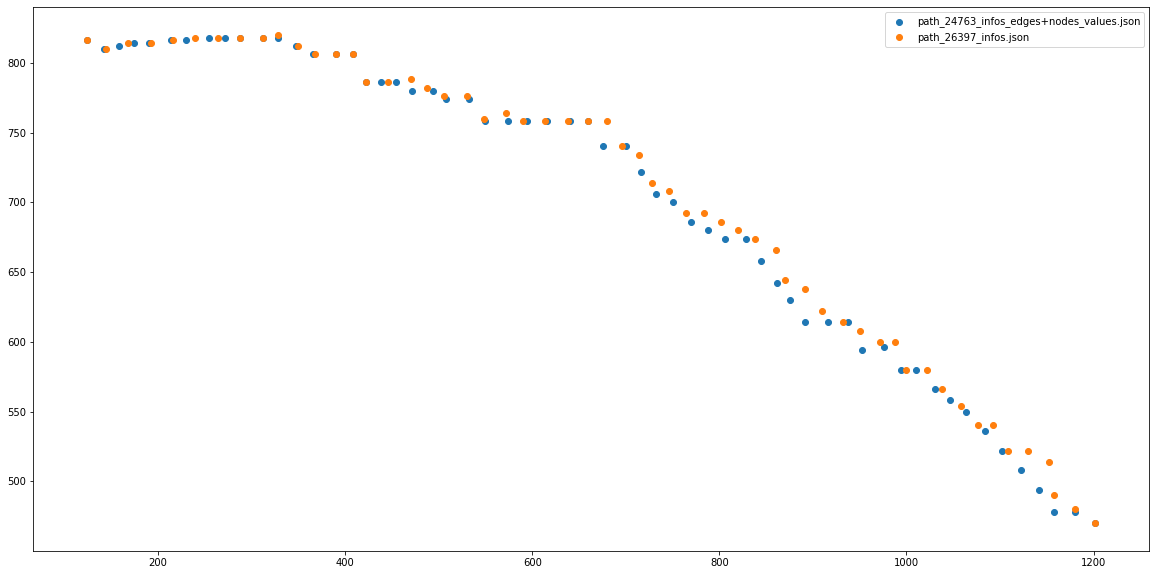

In [625]:
plt.figure(figsize=(20,10))
for p, f in zip(paths, files):
    p_arr = np.array(p)
    plt.scatter(p_arr[:,1], p_arr[:,0], label = f)
    print(f, "path length:", len(p))
plt.legend()
plt.show()

### Observations:

* Way more nodes in edge cost path
* Combining both --> edge cost seem to matter more (still 61 vs 52 nodes) --> would need to weight them somehow
* idea: adapt donut

### Timings

In [389]:
json_file_path = "../outputs/path_37054_directed_startend_infos.json"
with open(os.path.join(json_file_path),"r") as infile:
    infos = json.load(infile)

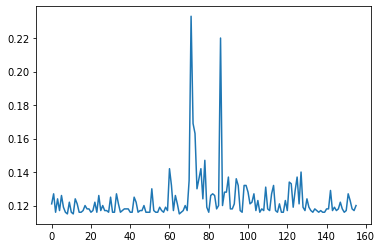

In [390]:
plt.plot(infos["time_logs"]["edge_list_times"])
plt.show()

## Is adding edges faster when nodes are first added

In [693]:
g = Graph()

In [690]:
_ = g.add_vertex(200001)

In [682]:
import time

In [694]:
edges = [[i,i+1] for i in range(200000)]

In [695]:
tic = time.time()
g.add_edge_list(edges)
print(time.time()-tic)

0.1559162139892578


## Piecewise linear fit

In [618]:
import pwlf

In [626]:
x = p_arr[:,0]
y = p_arr[:,1]

In [633]:
my_pwlf = pwlf.PiecewiseLinFit(x,y)
breaks = my_pwlf.fit(7)

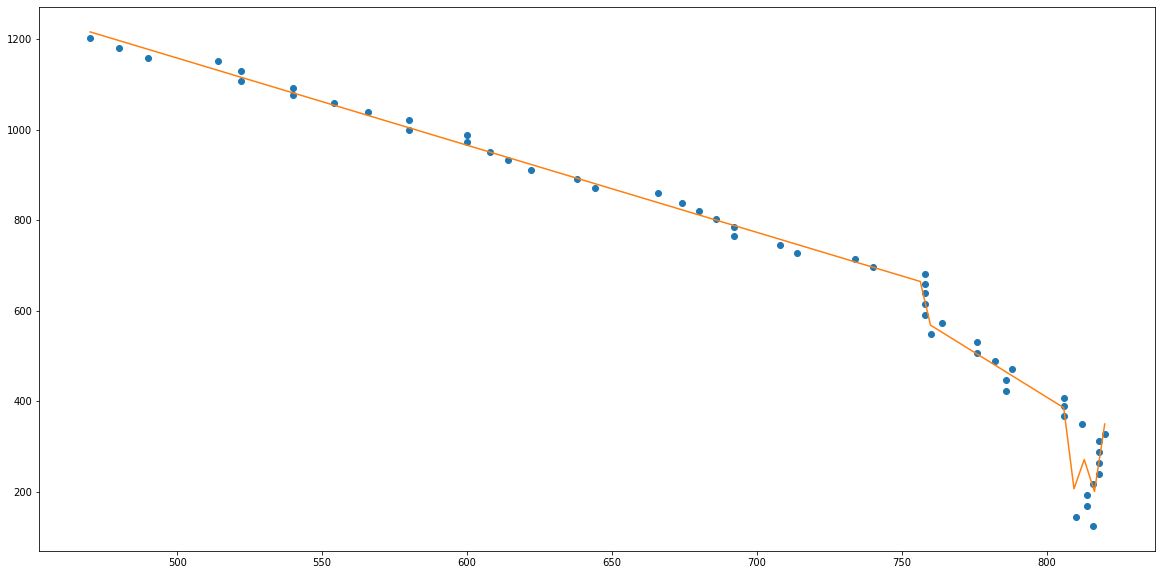

In [634]:
x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)

plt.figure(figsize=(20,10))
plt.plot(x, y, 'o')
plt.plot(x_hat, y_hat, '-')
plt.show()

## Weighted constraint

In [420]:
path_files = "/Users/ninawiedemann/Downloads/tifs_new"

In [424]:
weights = pd.read_csv(os.path.join(path_files,"layer_weights.csv"))

In [650]:
def read_tif(path):
    with rasterio.open(path, 'r') as ds:
        print(path)
        arr = ds.read()
    return arr[0]

### Forbidden ones

In [651]:
def get_hard_constraints(path_files, weights):
    hard_cons_rows = weights[weights["weight"]=="Forbidden"]
    hard_constraints = np.asarray([read_tif(os.path.join(path_files, "tif_layers", fname+".tif")) for fname in hard_cons_rows["Layer Name"]])
    # set to zero
    for hard in hard_constraints:
        plt.imshow(hard)
        plt.show()
    hard_constraints -= np.min(hard_constraints)
    hard_constraints = np.all(hard_constraints.astype(int), axis=0)
    return hard_constraints

/Users/ninawiedemann/Downloads/tifs_new/tif_layers/Buildingftp.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/BC_PAT_MONUMENTS.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/BC_PAT_PROTECT.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/PAT_EXC_MONUM.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/PAT_MND_MONUM.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/NATURA_2000_PERIMETRES.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/PDS_Reservat.tif
/Users/ninawiedemann/Downloads/tifs_new/tif_layers/Terrils.tif


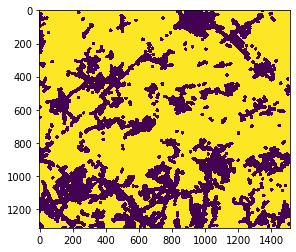

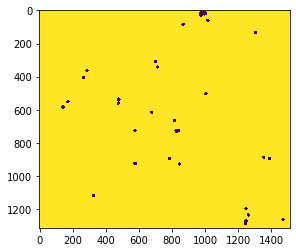

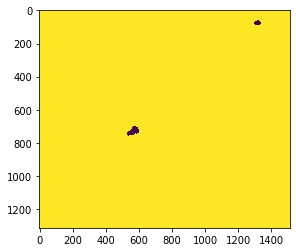

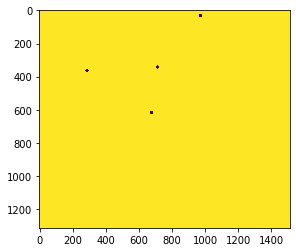

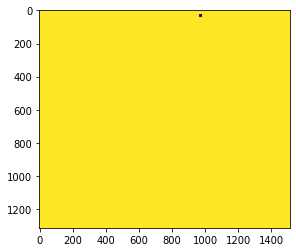

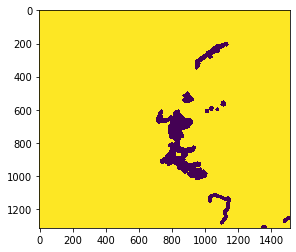

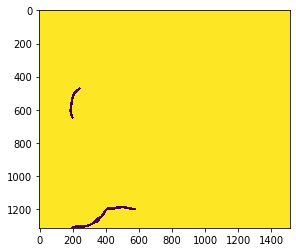

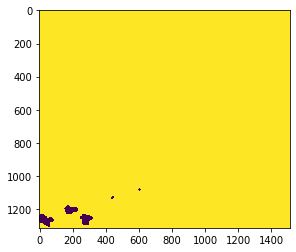

In [652]:
hard_constraints = get_hard_constraints(path_files, weights)

### Other ones

In [525]:
weights = weights.dropna()

In [526]:
layers = weights[weights["weight"]!="Forbidden"] # weights_wo_nan

In [557]:
GENERAL_SHAPE = (1313, 1511)

In [ ]:
cost_sum_arr = np.zeros(GENERAL_SHAPE)
for fname, weight in zip(layers["Layer Name"], layers["weight"]):
    file_path = os.path.join(path_files, "tif_layers", fname+".tif")
    if os.path.exists(file_path):
        costs = read_tif(file_path)
    costs = np.absolute(normalize(costs)-1)
    print(np.min(costs), np.max(costs))
    cost_sum_arr = cost_sum_arr + costs * int(weight)

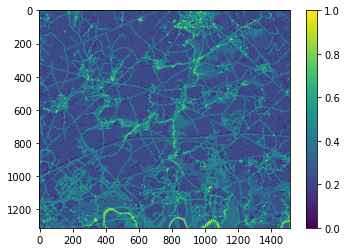

In [567]:
plt.imshow(normalize(cost_sum_arr))
plt.colorbar()
plt.show()

## Start and end

In [275]:
path_files = "/Users/ninawiedemann/Downloads/tif_ras_buf"

In [320]:
with rasterio.open(os.path.join(path_files, "corridor/CORRIDOR_BE.tif")) as dataset:
    # "/Users/ninawiedemann/Downloads/tifs_new/Destination.tif", 'r') as dataset:
    print(dataset.width)
    print(dataset.bounds)
    transform_matrix = dataset.transform
    arr = dataset.read()
    print(arr.shape)
    print(dataset.crs)

1511
BoundingBox(left=163246.2068, bottom=126131.1214, right=178356.2068, top=139261.1214)
(1, 1313, 1511)
EPSG:31370


In [639]:
a = np.zeros((20,20))

In [642]:
a[:5, 1] = 1
a[4, 1:8]=1
a[4, 10]=1
a[7:15, 10] = 1
a[14, 10] = 1
a[14, 13:15] = 1
a[14:, 14] = 1

start = [0,1]
end = [19, 14]
a[start[0], start[1]] = 2

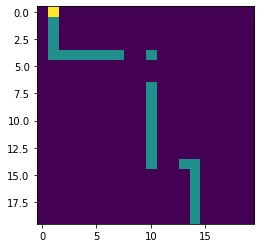

In [643]:
plt.imshow(a)
plt.show()

In [603]:
arr2 = read_tif(os.path.join(path_files, "corridor/CORRIDOR_BE.tif"))

In [606]:
corridor = arr2!=9999

In [656]:
together = corr.astype(int)*hard_constraints

In [657]:
together.shape

(1313, 1511)

In [662]:
np.pad(together, ((1,1), (1,1))).shape

(1315, 1513)

In [654]:
corr = np.zeros(together.shape)
corr[40:1260, 200:1000] =1

In [667]:
x_inds, y_inds = np.where(corr)
x_len, y_len = corr.shape
min_dist = min([x_inds[0], x_len-x_inds[-1], y_inds[0], y_len-y_inds[-1]])

40


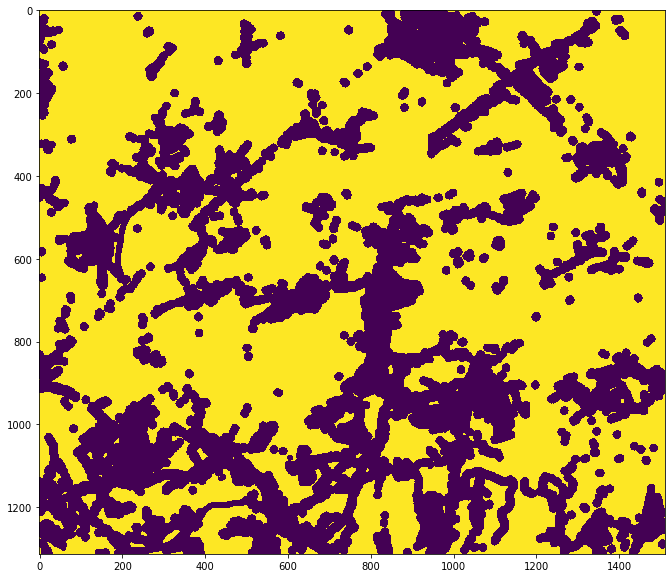

In [668]:
plt.figure(figsize=(20,10))
plt.imshow(hard_constraints)# [600:800, 300:720]) # np.swapaxes(arr[0], 0,1)) # , origin="lower")
plt.show()

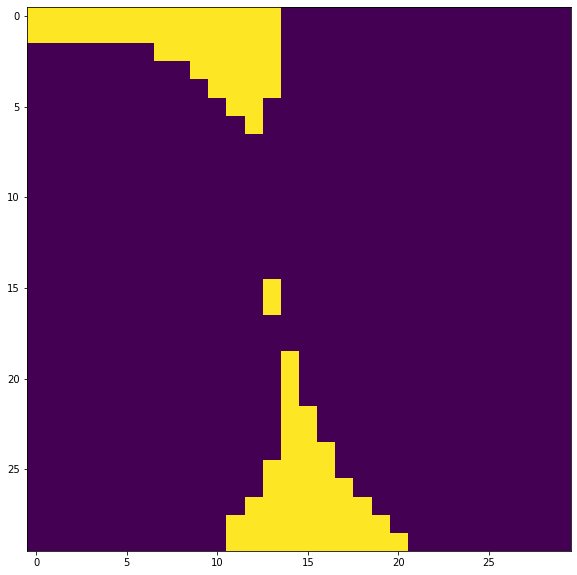

In [644]:
plt.figure(figsize=(20,10))
together[650:]
plt.imshow(together[650:680, 690:720]) # np.swapaxes(arr[0], 0,1)) # , origin="lower")
plt.show()

In [258]:
import shapefile
sf = shapefile.Reader("/Users/ninawiedemann/Downloads/tifs_new/Destination")

In [269]:
shapes = sf.shapes()

In [272]:
shapes[0].points

[[167956.27305673048, 127231.34509884659]]

In [318]:
with open("/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/path_37054_directed_startend_infos.json", "r") as infile:
    coords = json.load(infile)

In [338]:
from pyproj import Proj, transform
inProj = Proj(init=dataset.crs)
outProj = Proj(init='epsg:4326')
x1,y1 =126131.1214, 178356.2068
x2,y2 = transform(inProj,outProj,x1,y1)
transformed = []
for point in coords["path_cells"]:
    trans = transform_matrix * point
    x2,y2 = transform(inProj,outProj,trans[0],trans[1])
    transformed.append([y2,x2])

/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [341]:
df.to_csv("test.csv")

In [340]:
df = pd.DataFrame(transformed)

In [348]:
df = df.rename(columns={"0": "Lat", "1": "Long"})

### Convert to correct coordinates

In [358]:
coords_arr = np.asarray(coords["path_cells"])
switched = np.roll(coords_arr, 1, axis=1)
coords_arr = np.asarray([list(transform_matrix*switched[i]) for i in range(len(switched))])

In [374]:
df = pd.DataFrame(coords_arr, columns=["X", "Y"])
# df.to_csv("converted_coords.csv")

## Optimize convolution

In [16]:
import numpy as np

from power_planner.utils import get_half_donut


def bresenham_line(x0, y0, x1, y1):
    """
    find pixels on line between two pixels
    https://stackoverflow.com/questions/50995499/generating-pixel-values-of-line-connecting-2-points
    """
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    switched = False
    if x0 > x1:
        switched = True
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    if y0 < y1:
        ystep = 1
    else:
        ystep = -1

    deltax = x1 - x0
    deltay = abs(y1 - y0)
    error = -deltax / 2
    y = y0

    line = []
    for x in range(x0, x1 + 1):
        if steep:
            line.append([y, x])
        else:
            line.append([x, y])

        error = error + deltay
        if error > 0:
            y = y + ystep
            error = error - deltax
    if switched:
        line.reverse()
    return line


def get_kernel(shifts):
    """
    Get all kernels describing the path of the edges in a discrete raster
    :param shifts: possible circle points
    :returns kernel: all possible kernels (number of circle points x upper x upper)
    :returns posneg: a list indicating whether it is a path to the left (=1) or to the right(=0)
    """
    upper = np.amax(np.absolute(shifts)) + 1
    posneg = []
    kernel = np.zeros((len(shifts), upper, upper))

    for i, shift in enumerate(shifts):
        if shift[1] < 0:
            posneg.append(1)
            line = bresenham_line(0, upper - 1, shift[0], upper - 1 + shift[1])
        else:
            posneg.append(0)
            line = bresenham_line(0, 0, shift[0], shift[1])
        # add points of line to the kernel
        for (j, k) in line:
            kernel[i, j, k] += 1
    return kernel, posneg


def convolve(img, kernel, neg=0):
    """
    Convolve a 2d img with a kernel, storing the output in the cell 
    corresponding the the left or right upper corner 
    :param img: 2d numpy array
    :param kernel: kernel (must have equal size and width)
    :param neg: if neg=0, store in upper left corner, if neg=1, store in upper 
    right corner
    :return convolved image of same size
    """
    k_size = len(kernel)
    if neg:
        padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    else:
        padded = np.pad(img, ((0, k_size), (0, k_size)))
    # print(padded.shape)
    convolved = np.zeros(img.shape)
    w, h = img.shape
    for i in range(0, w):
        for j in range(0, h):
            patch = padded[i:i + k_size, j:j + k_size]
            convolved[i, j] = np.sum(patch * kernel)
    return convolved


def angle(path):
    path = np.asarray(path)
    for p, (i, j) in enumerate(path[:-2]):
        v1 = path[p + 1] - path[p]
        v2 = path[p + 1] - path[p + 2]
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        angle = np.arccos(np.dot(v1, v2))
        if angle < np.pi:
            pass


# Questions:
## altitude leads to more costs for pylons? because they are higher?

# height profile constraints:
## simply exclude edges which cannot be placed --> only works when iterating over edges

## Angle constraints:
# * line graph
# * path straighening toolbox


In [14]:
arr = np.arange(0,81,1).reshape((9,9))
arr

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]])

In [210]:
shifts = get_half_donut(3, 8)
kernel, posneg = get_kernel(shifts)

In [225]:
kernel[14]

array([[0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [227]:
convolve(arr, kernel[14], 1)

array([[  0.,   1.,  12.,  24.,  37.,  51.,  75., 100., 108.],
       [  9.,  19.,  39.,  60.,  82., 105., 138., 172., 180.],
       [ 18.,  37.,  66.,  96., 127., 159., 201., 244., 252.],
       [ 27.,  55.,  93., 132., 172., 213., 264., 316., 324.],
       [ 36.,  73., 120., 168., 217., 267., 327., 388., 396.],
       [ 45.,  91., 147., 204., 262., 321., 390., 460., 468.],
       [ 54., 109., 174., 240., 307., 375., 453., 532., 540.],
       [ 63., 127., 201., 276., 352., 429., 435., 441., 447.],
       [ 72., 145., 147., 149., 151., 153., 155., 157., 159.]])

In [26]:
from scipy.signal import convolve2d

In [232]:
def convolve_faster(img, f, neg):
    k_size = len(f)
    # a = np.pad(img, ((0, k_size-1), (0, k_size-1)))
    if neg:
        padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    else:
        padded = np.pad(img, ((0, k_size - 1), (0, k_size - 1)))
    
    s = f.shape + tuple(np.subtract(padded.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(padded, shape = s, strides = padded.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

In [233]:
arr2 = convolve_faster(arr, kernel[14], 1) # [5:-2, 2:-5] # 8x8
# [3:-6, 9:] # for 10x10 kernel, 1:-3,3:-1] # for 5x5 kernel

In [234]:
arr2

array([[  0.,   1.,  12.,  24.,  37.,  51.,  75., 100., 108.],
       [  9.,  19.,  39.,  60.,  82., 105., 138., 172., 180.],
       [ 18.,  37.,  66.,  96., 127., 159., 201., 244., 252.],
       [ 27.,  55.,  93., 132., 172., 213., 264., 316., 324.],
       [ 36.,  73., 120., 168., 217., 267., 327., 388., 396.],
       [ 45.,  91., 147., 204., 262., 321., 390., 460., 468.],
       [ 54., 109., 174., 240., 307., 375., 453., 532., 540.],
       [ 63., 127., 201., 276., 352., 429., 435., 441., 447.],
       [ 72., 145., 147., 149., 151., 153., 155., 157., 159.]])

In [ ]:
def convolve_faster(img, kernel, neg):
    k_size = len(kernel)
    print(k_size)
    # print(k_size)
    # if neg:
    #     padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    # else:
    #     padded = np.pad(img, ((0, k_size), (0, k_size)))
    padded = np.pad(img, ((0, k_size), (0, k_size)))
    print(padded.astype(int))
    print(kernel)
    return convolve2d(padded, kernel, mode ="same")[:-k_size-4, :-k_size-4]
# 8x8: [1:-k_size+1, 1:-k_size+1] 
# 7x7 [2:-k_size+2, :-k_size]
# 6x6 [3:-k_size+3, 1:-k_size+1]
# 5x5 

In [197]:
arr2

array([[ 147.,  195.,  247.,  267.,  287.],
       [ 258.,  345.,  437.,  462.,  487.],
       [ 396.,  531.,  672.,  702.,  732.],
       [ 558.,  747.,  942.,  972., 1002.],
       [ 720.,  963., 1212., 1242., 1272.]])

In [82]:
kernel[33].shape

(10, 10)